In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score

%matplotlib inline

### Предсказание площади лесных пожаров. 

Загрузим датасет погодных измерений и обьема выгоревших лесных массивов на севере Португалии. Выборка состоит из 13 признаков и 517 объектов.

In [2]:
df = pd.read_csv("/Users/Nina/Downloads/forestfires.csv", sep=',')
#df = shuffle(df, random_state=7)
df.head(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
5,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0
7,8,6,aug,mon,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0
8,8,6,sep,tue,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.0
9,7,5,sep,sat,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,0.0


Преобразуем признаки. Вместо названия месяца создадим 12 признаков-индиаторов, вместо названия дня недели запишем 7 признаков-индикаторов. Создадим двумерный массив из измерений(data) и одномерный с результатом(result) - площадью пожара для данного набора признаков.

In [3]:
features = df.columns.get_values()
n_features = len(features)
n_lines = len(df)
print("Названия признаков:", features.tolist())
print("Названия месяцев:", np.unique(np.array(df.month)))
print("Названия дней недели:", np.unique(np.array(df.day)))

Названия признаков: ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']
Названия месяцев: ['apr' 'aug' 'dec' 'feb' 'jan' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
Названия дней недели: ['fri' 'mon' 'sat' 'sun' 'thu' 'tue' 'wed']


In [4]:
number_month = {'apr':4, 'aug':8, 'dec':12, 'feb':2, 
                'jan':1, 'jul':7, 'jun':6, 'mar':3, 
                'may':5, 'nov':11, 'oct':10, 'sep':9}
number_day = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5, 'sat':6, 'sun':7}

data_save = np.array(df[features])
result = []
start_data = []

print("Пример преобразования данных\n")
print("Была строка признаков:", data_save[0])

for line in data_save:
    line[2] = number_month.get(line[2])
    line[3] = number_day.get(line[3]) 
    new_line = np.copy(line).tolist()[:-1]
    new_line = new_line[4:-1]
    new_line.append(line[0])
    new_line.append(line[1])
    for i in range(1, 13):
        new_line.append(1 if line[2] == i else 0)
    for i in range(1, 8):
        new_line.append(1 if line[3] == i else 0)
    start_data.append(new_line)
    result.append(line[-1])
    
start_data = np.array(start_data)
print("Стала строка признаков:", start_data[0])

Пример преобразования данных

Была строка признаков: [7 5 'mar' 'fri' 86.2 26.2 94.3 5.1 8.2 51 6.7 0.0 0.0]
Стала строка признаков: [86.2 26.2 94.3  5.1  8.2 51.   6.7  7.   5.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0. ]


Для решения задачи предсказания будем использовать линейную регрессию для метрики MSE с $L_2$-регуляризацией с параметром $\lambda$. Т.е. задача оптимизации: $$L=\left\{ x_i, y_i  \right\}_{i=1}^n, \;\; x \in \mathbb{R}^p, y \in \mathbb{R}$$ 
Ищем решение в виде $$\widehat{y_i} = w_0 + w_1 x_1 + ... + w_p x_p,$$ где $w=(w_1, ..., w_p)$ вектор весов, $w_0$ - bias term.
$$\widehat{w} = \underset{w}argmin Q(w),$$ где $Q(w)$ - функция потерь.
$$Q(w) = ||Y-Xw||^2_2 + \lambda^2 ||w||^2$$

Для различных $\lambda$ посчитаем среднюю ошибку MSE на кросс-валидации. Построим графики.

[86.2 26.2 94.3  5.1  8.2 51.   6.7  7.   5.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0. ]


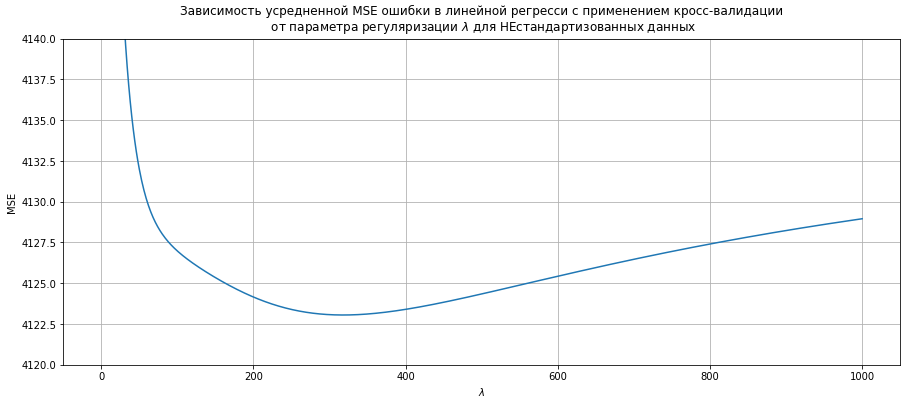

In [5]:
mse = []
res = []

data = start_data
print(data[0])

grid = np.linspace(0.0001, 1000, 1000)
for lmbd in grid:
    alpha = lmbd ** 2
    lr = Ridge(alpha=alpha)
    fin = cross_val_score(lr, data, result, cv=5, scoring='neg_mean_squared_error')
    mse.append(-np.mean(fin))
    #res.append(lr.coef_.tolist())
    
res = np.array(res)
    
"""plt.figure(figsize=(15, 9))
for i in range(len(res[0])):
    plt.plot(grid, res[:, i], label = str(i))
plt.legend()
plt.show()"""

plt.figure(figsize=(15, 6))
plt.plot(grid, mse)
plt.grid()
plt.ylim((4120, 4140))
plt.title('Зависимость усредненной MSE ошибки в линейной регресси с применением кросс-валидации\n от параметра регуляризации $\\lambda$ для НЕстандартизованных данных')
plt.ylabel('MSE')
plt.xlabel('$\\lambda$')
plt.show()

Также подготовим стандартизованные данные. И проделаем то же самое для них.

In [6]:
scaler = StandardScaler()
scaler.fit(start_data)
data_st = scaler.transform(start_data)

[-0.80595947 -1.32332557 -1.83047676 -0.86094557 -1.84264015  0.41172435
  1.49861442  1.00831277  0.56986043 -0.0623177  -0.20060271  2.92815199
 -0.13310348 -0.0623177  -0.18439089 -0.25686452 -0.74333879 -0.70608125
 -0.17285971 -0.04402255 -0.13310348 -0.40870881 -0.37587279 -0.34151233
 -0.36574845  2.25440745 -0.44044907 -0.47446653]


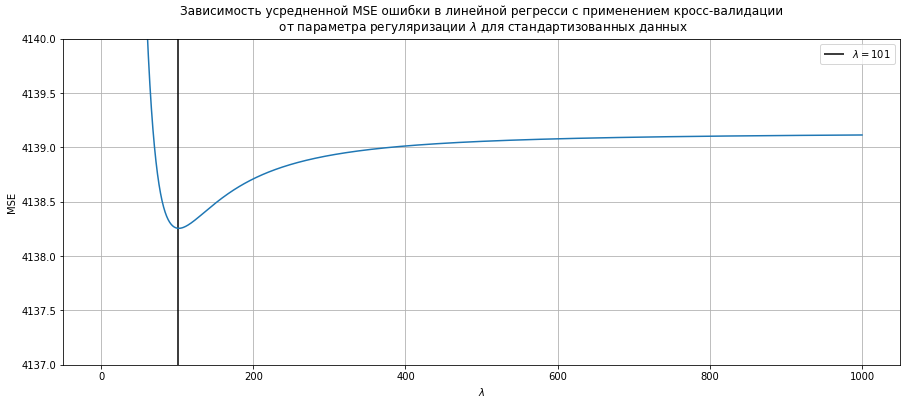

In [7]:
mse = []
res = []

data = data_st
print(data[0])

grid = np.linspace(0.0001, 1000, 1000)
for lmbd in grid:
    alpha = lmbd ** 2
    lr = Ridge(alpha=alpha)
    fin = cross_val_score(lr, data, result, cv=5, scoring='neg_mean_squared_error')
    mse.append(-np.mean(fin))
    #res.append(lr.coef_.tolist())
    
res = np.array(res)
    
"""plt.figure(figsize=(15, 9))
for i in range(len(res[0])):
    plt.plot(grid, res[:, i], label = str(i))
plt.legend()
plt.show()"""

plt.figure(figsize=(15, 6))
plt.plot(grid, mse)
plt.ylim((4137, 4140))
plt.grid()
plt.title('Зависимость усредненной MSE ошибки в линейной регресси с применением кросс-валидации\n от параметра регуляризации $\\lambda$ для стандартизованных данных')
plt.ylabel('MSE')
plt.xlabel('$\\lambda$')
plt.vlines(101, 4137, 4140, label = "$\\lambda=101$")
plt.legend()
plt.show()

Теперь нарисуем графики зависимости весов от параметра регаляризации в случае стандартизованных признаков.

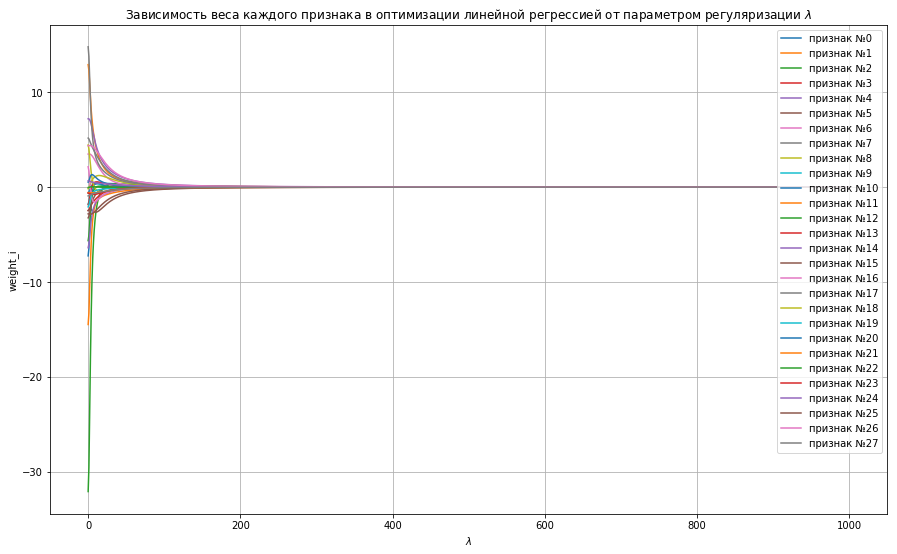

In [8]:
res = []

data = data_st

grid = np.linspace(0.0001, 1000, 1000)
for lmbd in grid:
    alpha = lmbd ** 2
    lr = Ridge(alpha=alpha)
    lr.fit(data, result)
    res.append(lr.coef_.tolist())
    
res = np.array(res)
    
plt.figure(figsize=(15, 9))
plt.title("Зависимость веса каждого признака в оптимизации линейной регрессией от параметром регуляризации $\\lambda$")
plt.ylabel('weight_i')
plt.xlabel('$\\lambda$')
for i in range(len(res[0])):
    plt.plot(grid, res[:, i], label = "признак №" + str(i))
plt.legend(loc=1)
plt.grid()
plt.show()

Увеличим изображение

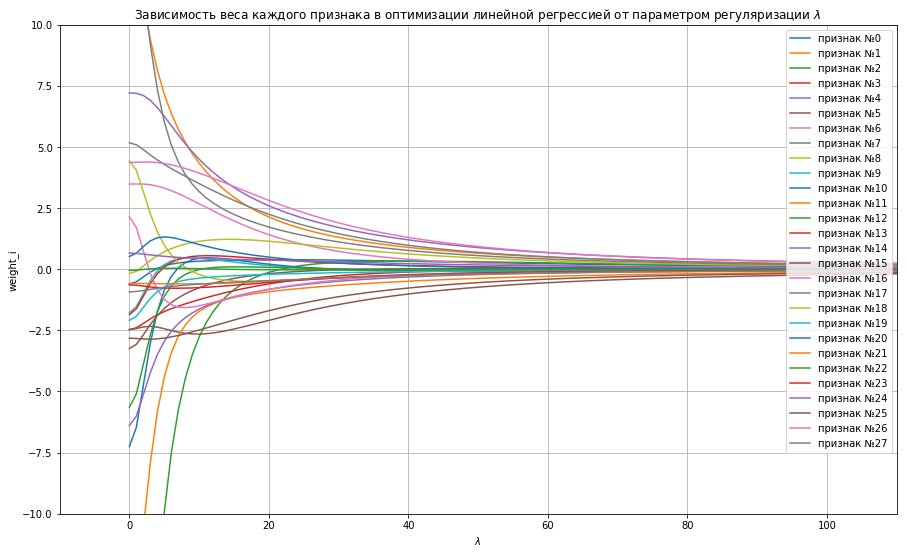

In [9]:
plt.figure(figsize=(15, 9))
for i in range(len(res[0])):
    plt.plot(grid, res[:, i], label = "признак №" + str(i))
plt.legend(loc=1)
plt.grid()
plt.title("Зависимость веса каждого признака в оптимизации линейной регрессией от параметром регуляризации $\\lambda$")
plt.ylabel('weight_i')
plt.xlabel('$\\lambda$')
plt.ylim((-10, 10))
plt.xlim((-10, 110))
plt.show()

Нарисуем область в районе $\lambda=100$.

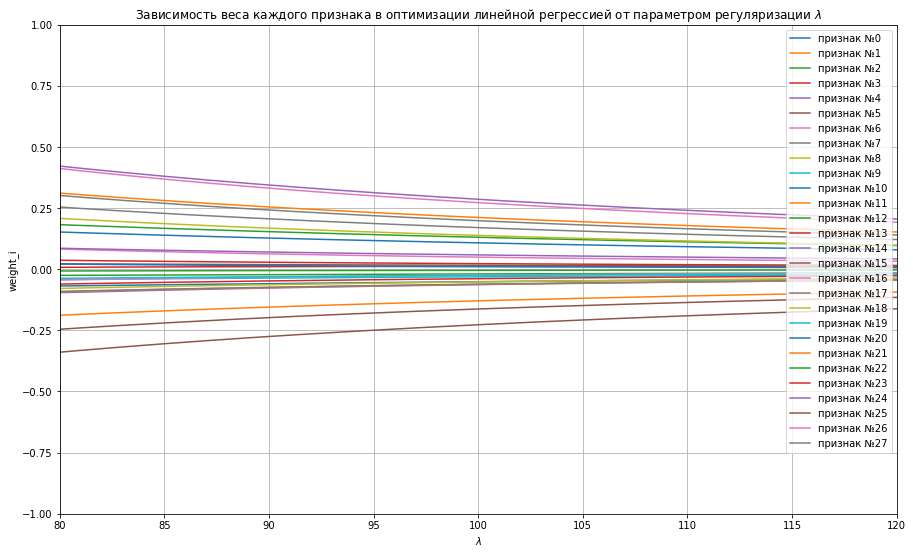

In [10]:
plt.figure(figsize=(15, 9))
for i in range(len(res[0])):
    plt.plot(grid, res[:, i], label = "признак №" + str(i))
plt.legend(loc=1)
plt.grid()
plt.title("Зависимость веса каждого признака в оптимизации линейной регрессией от параметром регуляризации $\\lambda$")
plt.ylabel('weight_i')
plt.xlabel('$\\lambda$')
plt.ylim((-1, 1))
plt.xlim((80, 120))
plt.show()

Чем больше модуль коэффициента весов, тем более значим признак. Можно отсортировать признаки по значимости в районе значения $\lambda$ равного 101. И, добавляя их по одному, посчитать MSE для решения найденного с помощью линейной регрессии с регуляризацией на сокращенном наборе признаков.

Сортируем признаки:

In [11]:
print(grid[101], res[101])
nw = []
i = 0
for el in res[101]:
    nw.append([np.abs(el), i])
    i += 1
nw.sort(reverse=True)
print(nw)

101.10119099099099 [ 0.10572336  0.20732667  0.12808977  0.0113117   0.28011992 -0.22260203
  0.04790033  0.19417671  0.13515721 -0.03084993 -0.05033715 -0.12697473
 -0.01910743  0.02208924 -0.06187142  0.01572541 -0.0236733   0.16656624
 -0.05097371 -0.02504178  0.01021944 -0.06094612 -0.00455415 -0.0379563
  0.05722167 -0.15941522  0.26644476 -0.05992567]
[[0.2801199207216381, 4], [0.26644475995020156, 26], [0.22260203198782988, 5], [0.20732666870161442, 1], [0.19417670674702478, 7], [0.16656624358508118, 17], [0.15941522130528493, 25], [0.13515720734914122, 8], [0.12808976995755147, 2], [0.12697473054651096, 11], [0.10572336113824156, 0], [0.06187141798349775, 14], [0.06094611628047239, 21], [0.059925668375379895, 27], [0.05722166864313193, 24], [0.050973705727270946, 18], [0.05033715217561628, 10], [0.04790032591534798, 6], [0.03795629902151476, 23], [0.030849934148884258, 9], [0.02504177541318851, 19], [0.023673297251089947, 16], [0.022089240273787062, 13], [0.01910743256444097, 1

Рисуем график MSE на test и на train:

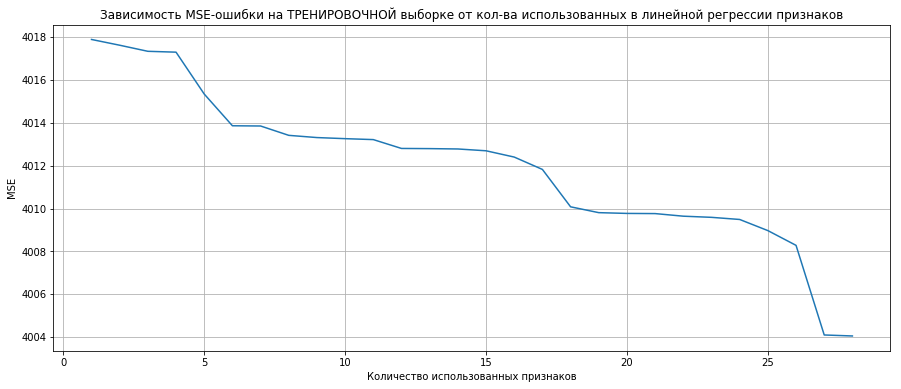

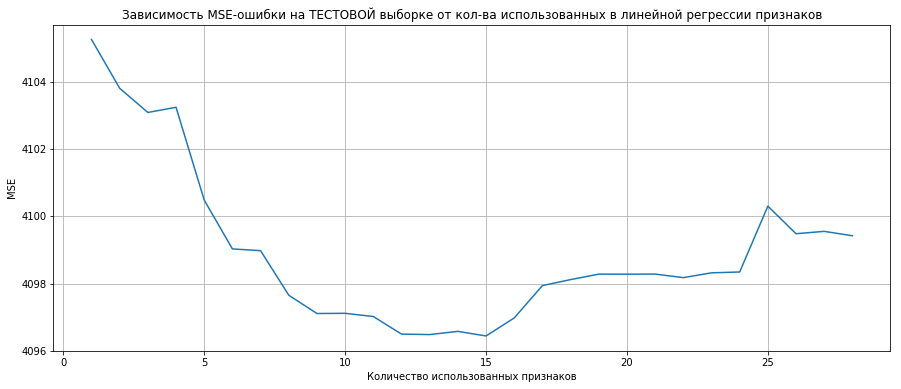

In [12]:
random_states = np.arange(23, 24)

for r in random_states:
    
    mse_train = []
    mse_test = []

    data_train, data_test, res_train, res_test = train_test_split(data_st, result, test_size=0.3, random_state=r)

    data_train = np.array(data_train)
    data_test = np.array(data_test)

    lmbd=101
    alpha = lmbd ** 2

    grid = np.arange(1, len(nw) + 1)

    for i in grid:
        lr = Ridge(alpha=alpha)
        lr.fit(data_train[:,: i], res_train)
        mse_train.append(mean_squared_error(lr.predict(data_train[:, :i]), res_train))
        mse_test.append(mean_squared_error(lr.predict(data_test[:, :i]), res_test))
    
    plt.figure(figsize=(15, 6))
    plt.plot(grid, mse_train, label = 'mse_train')
    plt.title("Зависимость MSE-ошибки на ТРЕНИРОВОЧНОЙ выборке от кол-ва использованных в линейной регрессии признаков")
    plt.ylabel('MSE')
    plt.xlabel('Количество использованных признаков')
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(15, 6))
    plt.title("Зависимость MSE-ошибки на ТЕСТОВОЙ выборке от кол-ва использованных в линейной регрессии признаков")
    plt.ylabel('MSE')
    plt.xlabel('Количество использованных признаков')
    plt.plot(grid, mse_test)
    plt.grid()
    plt.show()

Значит имеем смысл брать порядка 12-15 самых значимых признаков.